In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.models.feature import Window
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.sand import SAND
from TSB_UAD.models.matrix_profile import MatrixProfile
from StreamingBatchIForest import StreamingBatchIForest

Dataset loading and preparation

In [2]:
# Load all time series from the YAHOO domain
public_root = "./data/"
selected_domain = 'YAHOO'
series_list, label_list = [], []
dom_path = os.path.join(public_root, selected_domain)
files = sorted(f for f in os.listdir(dom_path) if f.endswith('.out'))  # Ensure consistent ordering

# Keep only the first i files
i=4
for f in files:
    file_path = os.path.join(dom_path, f)
    df = pd.read_csv(file_path, header=None).dropna()
    data = df.iloc[:, 0].astype(float).to_numpy()
    label = df.iloc[:, 1].astype(int).to_numpy()
    series_list.append(data)
    label_list.append(label)
    i-=1
    if i == 0:  
        break

# Create cumulative time series and labels
series = []
labels = []
for i in range(1, len(series_list) + 1):
    cum_ts = np.concatenate(series_list[:i], axis=0)
    cum_labels = np.concatenate(label_list[:i], axis=0)
    series.append(cum_ts)
    labels.append(cum_labels)


# Create different-normalities time series
norm1_ts = series[0]
norm1_labels = labels[0]
norm2_ts = series[1] if len(series) > 1 else None
norm2_labels = labels[1] if len(labels) > 1 else None
norm3_ts = series[2] if len(series) > 2 else None
norm3_labels = labels[2] if len(labels) > 2 else None
norm4_ts = series[3] if len(series) > 3 else None
norm4_labels = labels[3] if len(labels) > 3 else None

series = [norm1_ts, norm2_ts, norm3_ts, norm4_ts]
labels = [norm1_labels, norm2_labels, norm3_labels, norm4_labels]

In [3]:
# Select normality norm
norm = 2
data = series[norm-1]
label = labels[norm-1]

Offline (Task 4)

In [ ]:
### Offline 1 - IForest
modelName='IForest'
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()
clf = IForest(n_jobs=1)
clf.fit(X_data)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
# plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

In [ ]:
### Offline 2 - MatrixProfile
modelName='MatrixProfile'
slidingWindow = find_length(data)
X_data = data
clf = MatrixProfile(window = slidingWindow)
clf.fit(X_data)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
# plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

In [ ]:
### Offline 3 - SAND
modelName='SAND (offline)'
slidingWindow = find_length(data)
X_data = data
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
clf.fit(X_data,overlaping_rate=int(1.5*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
#plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

Online (Tasks 5 and 6)

In [38]:
## Variant 1 - Batching
batch_size = 500
batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

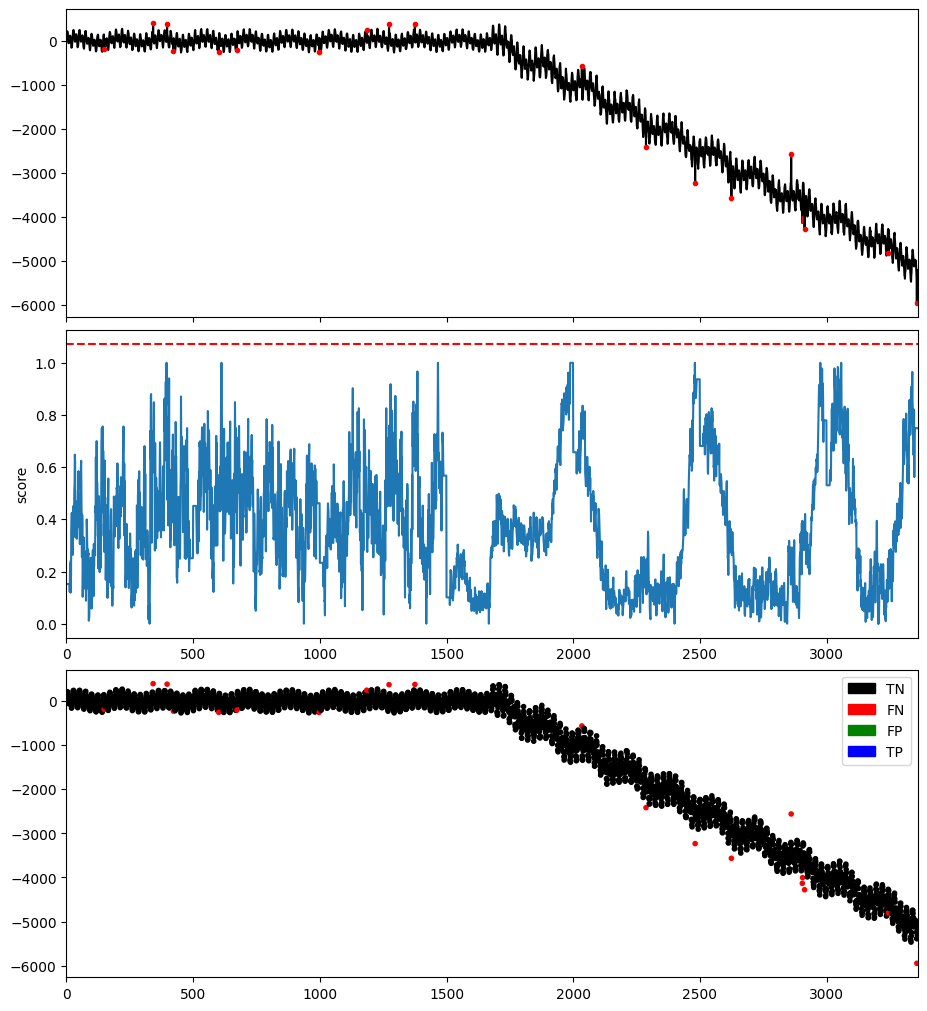

In [39]:
### Batch 1 - IForest
modelName='IForest (batches)'
slidingWindow = find_length(batches[0])
for i, batch in enumerate(batches):
    X_data = Window(window=slidingWindow).convert(batch).to_numpy()
    clf = IForest(n_jobs=1)
    clf.fit(X_data)
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

    if i == 0:
        final_score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    else:
        final_score = np.concatenate((final_score, [score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2)))    

plotFig(data, label, final_score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
#plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

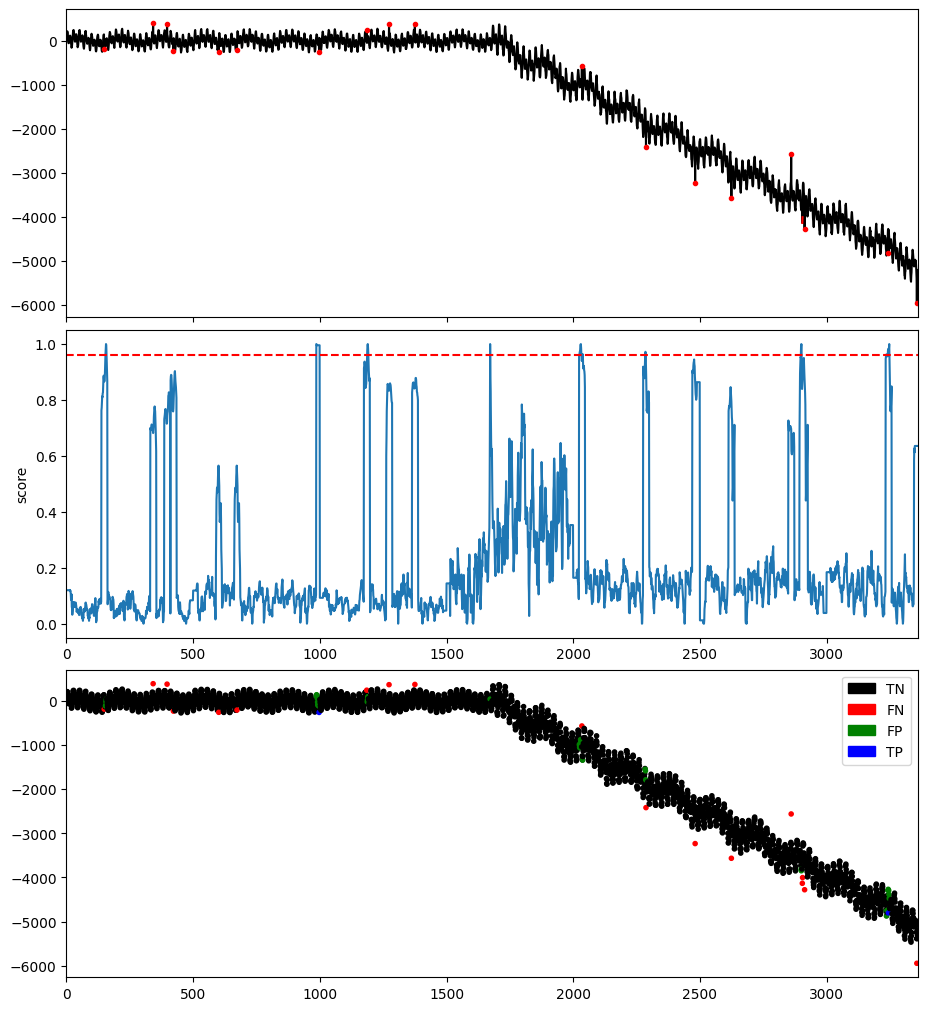

In [40]:
### Batch 2 - MatrixProfile
modelName='MatrixProfile (batches)'
for i, batch in enumerate(batches):
    slidingWindow = find_length(batch) # Is it OK to recompute the sliding window length for each batch?
    X_data = batch
    clf = MatrixProfile(window = slidingWindow)
    clf.fit(X_data)
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    
    if i == 0:
        final_score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    else:
        final_score = np.concatenate((final_score, [score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2)))    

plotFig(data, label, final_score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
#plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

0-->

/home/balaktsis/Projects/msc/StreamingAnomalyDetection/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/balaktsis/Projects/msc/StreamingAnomalyDetection/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/balaktsis/Projects/msc/StreamingAnomalyDetection/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/balaktsis/Projects/msc/StreamingAnomalyDetection/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/balaktsis/Projects

[STOP]: score length 3360


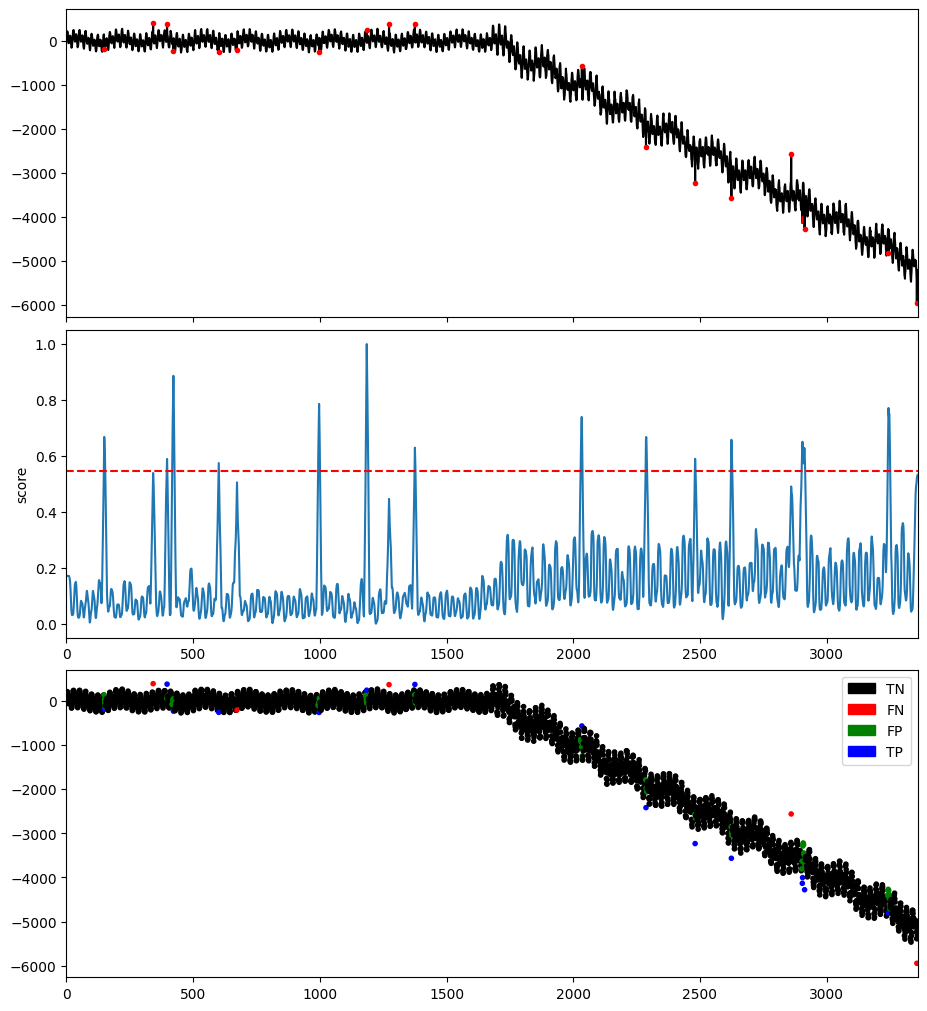

In [41]:
### Batch 3 - SAND
modelName='SAND (online)'
slidingWindow = find_length(data)
X_data = data
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
clf.fit(X_data,online=True,alpha=0.5,init_length=5000,batch_size=2000,verbose=True,overlaping_rate=int(4*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
#plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

In [ ]:
# Variant 2 - Streaming

In [ ]:
### Online 1 - IForest
sb_if = StreamingBatchIForest(
    batch_frac=0.1,
    overlap=10,
    n_clusters=4,
    state_size=None,       
    tabpfn_device='cpu'
)
scores = sb_if.process(data)
sliding = find_length(data)
plotFig(data, label, scores, sliding, fileName='Stream_IForest', modelName='StreamIForest')
plt.show()
#plt.savefig('Stream_IForest.png', dpi=300, bbox_inches='tight')